In [1]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

#Importing the data
df_credit = pd.read_csv("german_credit_data.csv",index_col=0)

<Axes: xlabel='Risk', ylabel='count'>

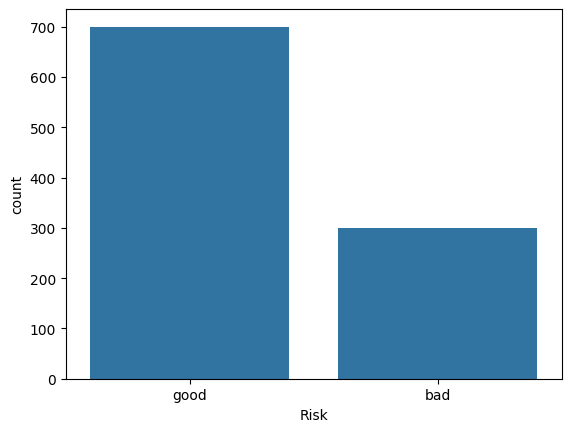

In [2]:
#Check distribution of Risk
sns.countplot(x='Risk',data=df_credit)

In [3]:
#oversample point for risk = "bad"
df_credit_bad = df_credit[df_credit['Risk'] == 'bad']
#create a new points for risk = "bad" using .sample
df_credit_bad_oversample = df_credit_bad.sample(n=400, replace=True, random_state=42)
#concatenate the oversample points with the original dataset
df_credit = pd.concat([df_credit, df_credit_bad_oversample], axis=0)

<Axes: xlabel='Risk', ylabel='count'>

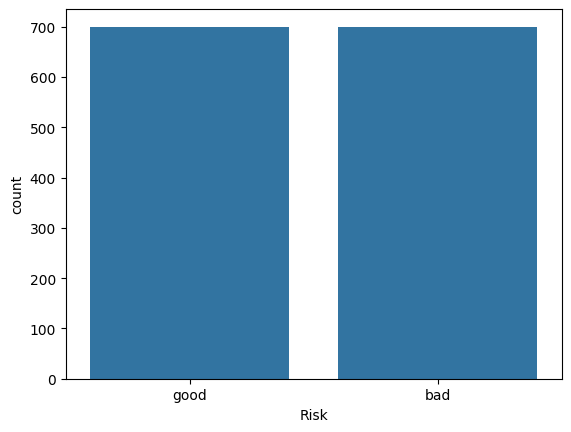

In [4]:
#Check distribution of Risk
sns.countplot(x='Risk',data=df_credit)

In [5]:
#check nan values
df_credit.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     228
Checking account    457
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [6]:
#converting age into categorical
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']

df_credit['Age'] = pd.cut(df_credit['Age'], bins=interval, labels=cats)

#set data type to object
df_credit['Age'] = df_credit['Age'].astype('object')



In [7]:
#converting jobs to categorical numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled, number to string
df_credit['Job'] = df_credit['Job'].astype(str)
df_credit['Job'] = df_credit['Job'].replace({'0': 'unskilled and non-resident', '1': 'unskilled and resident', '2': 'skilled', '3': 'highly skilled'})

In [8]:
#converting duration from months to 0-1 years, 1-2 years, 2-3 years, >3 years
interval = (0, 12, 24, 36, 1000)
cats = ['0-1 years', '1-2 years', '2-3 years', '>3 years']
df_credit['Duration'] = pd.cut(df_credit['Duration'], bins=interval, labels=cats)

#convverting duration to object
df_credit['Duration'] = df_credit['Duration'].astype('object')

In [9]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [10]:
# call the function
df_credit, cat_cols = one_hot_encoder(df_credit, nan_as_category= True)

In [11]:
#count of vals in each column
for col in df_credit.columns:
    print(f"{col}: {df_credit[col].nunique()} unique values")

Credit amount: 921 unique values
Age_Senior: 2 unique values
Age_Student: 2 unique values
Age_Young: 2 unique values
Age_nan: 1 unique values
Sex_male: 2 unique values
Sex_nan: 1 unique values
Job_skilled: 2 unique values
Job_unskilled and non-resident: 2 unique values
Job_unskilled and resident: 2 unique values
Job_nan: 1 unique values
Housing_own: 2 unique values
Housing_rent: 2 unique values
Housing_nan: 1 unique values
Saving accounts_moderate: 2 unique values
Saving accounts_quite rich: 2 unique values
Saving accounts_rich: 2 unique values
Saving accounts_nan: 2 unique values
Checking account_moderate: 2 unique values
Checking account_rich: 2 unique values
Checking account_nan: 2 unique values
Duration_1-2 years: 2 unique values
Duration_2-3 years: 2 unique values
Duration_>3 years: 2 unique values
Duration_nan: 1 unique values
Purpose_car: 2 unique values
Purpose_domestic appliances: 2 unique values
Purpose_education: 2 unique values
Purpose_furniture/equipment: 2 unique values
P

In [12]:
df_credit.drop(columns=['Risk_nan','Purpose_nan','Job_nan','Housing_nan','Sex_nan',"Age_nan","Duration_nan"], inplace=True)

<Axes: xlabel='Credit amount', ylabel='Count'>

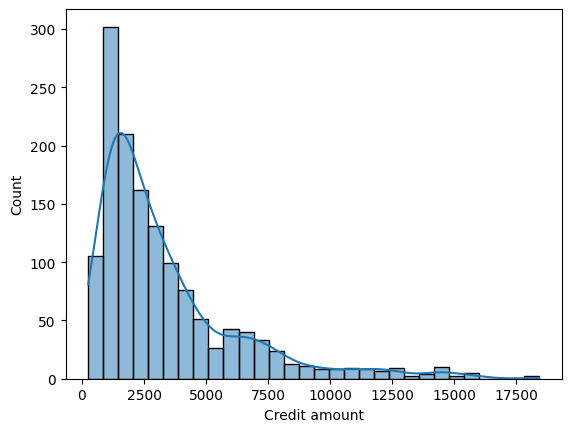

In [13]:
#check distribution of "Credit amount"
sns.histplot(df_credit['Credit amount'], bins=30, kde=True)

Text(0.5, 1.0, 'Correlation Matrix')

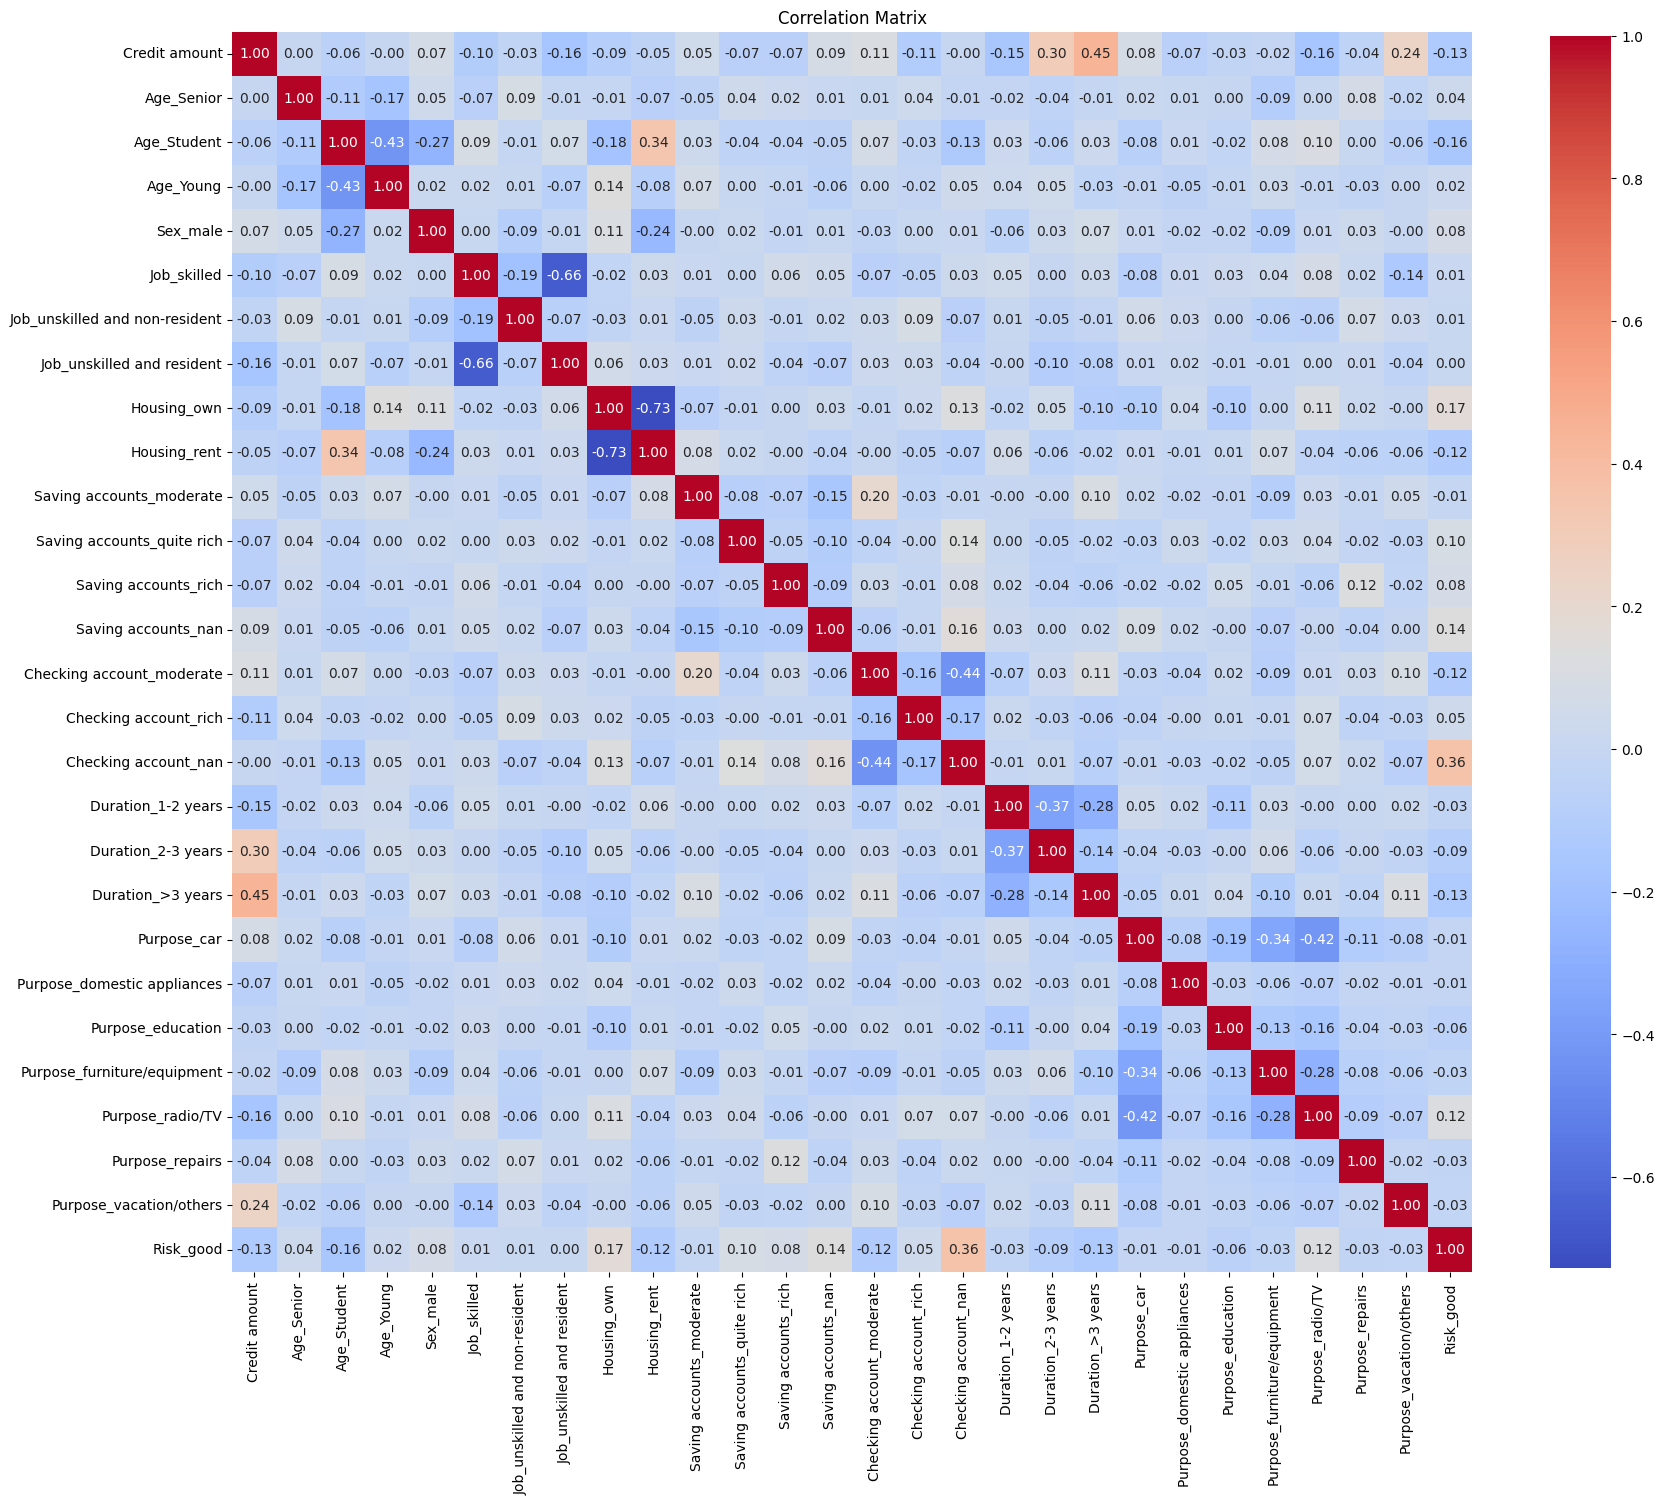

In [14]:
#correlation matrix
corr = df_credit.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#defin function for dpd score
def dpd_score(y,sensitive_column):
    req_cols = ['Risk_good', sensitive_column]
    df = y[req_cols]
    
    #group by sensitive column
    df = df.groupby(sensitive_column).agg({'Risk_good': 'mean'}).reset_index()

    #calculate dpd score
    dpd_score = df['Risk_good'].max() - df['Risk_good'].min()
    return dpd_score  
#create custom loss function
def custom_loss(y_true, y_pred, alpha=0.5):
    #convert y_true and y_pred to dataframe
    y_true = pd.DataFrame(y_true, columns=['Risk_good'])
    y_pred_acc = pd.DataFrame(y_pred, columns=['Risk_good'])

    score_acc = accuracy_score(y_true, y_pred_acc)
    score_dpd = dpd_score(y_pred, 'Sex_male')


    #calculate custom loss
    loss = alpha * (1 - score_acc) + (1 - alpha) * score_dpd
    return loss

In [21]:
#  save this df to a csv file 

df_credit.to_csv("german_credit_data_cleaned.csv", index=False)